In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from tqdm import tqdm
from IPython.display import Image
import seaborn as sns
import calmap
from datetime import datetime, timedelta
import math
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.tree import DecisionTreeRegressor as DecisionTree
from sklearn.ensemble import GradientBoostingRegressor as GradientBoosting
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
pd.options.mode.chained_assignment = None

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/vlad/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')

In [6]:
calendar = pd.read_csv('calendar.csv')
date=calendar.loc[:,['d','date']]
date.set_index('d', inplace=True)
date=date.reset_index(drop=True)
calendar.drop(index=np.arange(len(calendar)-1,len(calendar)-57, -1), inplace=True)

In [7]:
snap=calendar.drop(columns=['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1',
                           'event_type_1', 'event_name_2', 'event_type_2'])
snap['date']=pd.to_datetime(snap['date'])
snap.set_index('date', inplace=True)

snap['snap_CA'] = snap['snap_CA'].astype('float')
snap['snap_TX'] = snap['snap_TX'].astype('float')
snap['snap_WI'] = snap['snap_WI'].astype('float')

,snap_CA,snap_TX,snap_WI
date,,,
2011-01-29,0.0,0.0,0.0
2011-01-30,0.0,0.0,0.0
2011-01-31,0.0,0.0,0.0
2011-02-01,1.0,1.0,0.0
2011-02-02,1.0,0.0,1.0


In [9]:
weekday_features=calendar.drop(columns=['wm_yr_wk', 'wday', 'd', 'month', 'year', 'event_name_2', 'event_name_1',
                           'event_type_2', 'event_type_1', 'snap_CA', 'snap_TX', 'snap_WI'])
weekday_features['date']=pd.to_datetime(weekday_features['date'])
weekday_features.set_index('date', inplace=True)

weekday_features['is_saturday'] = weekday_features['weekday'] == 'Saturday'
weekday_features['is_saturday'] = weekday_features['is_saturday'].astype('float')

weekday_features['is_sunday'] = weekday_features['weekday'] == 'Sunday'
weekday_features['is_sunday'] = weekday_features['is_sunday'].astype('float')

weekday_features['is_monday'] = weekday_features['weekday'] == 'Monday'
weekday_features['is_monday'] = weekday_features['is_monday'].astype('float')

weekday_features['is_friday'] = weekday_features['weekday'] == 'Friday'
weekday_features['is_friday'] = weekday_features['is_friday'].astype('float')

weekday_features.drop(columns=['weekday'], inplace=True)
weekday_features.head()

,is_saturday,is_sunday,is_monday,is_friday
date,,,,
2011-01-29,1.0,0.0,0.0,0.0
2011-01-30,0.0,1.0,0.0,0.0
2011-01-31,0.0,0.0,1.0,0.0
2011-02-01,0.0,0.0,0.0,0.0
2011-02-02,0.0,0.0,0.0,0.0


In [11]:
events_features=calendar.drop(columns=['wm_yr_wk', 'weekday', 'year', 'd', 'wday', 'month',
                                       'snap_CA', 'snap_TX', 'snap_WI'])
events_features['date']=pd.to_datetime(events_features['date'])

events_features['is_day_off'] = (events_features.date.dt.day == 25) & (events_features.date.dt.month == 12)
events_features['is_day_off'] = events_features['is_day_off'].astype('float')

events_features.set_index('date', inplace=True)

events_features['is_sporting'] = (events_features.event_type_1 == 'Sporting') | (events_features.event_type_2 == 'Sporting')
events_features['is_sporting'] = events_features['is_sporting'].astype('float')

events_features['is_cultural'] = (events_features.event_type_1 == 'Cultural') | (events_features.event_type_2 == 'Cultural')
events_features['is_cultural'] = events_features['is_cultural'].astype('float')

events_features['is_national'] = (events_features.event_type_1 == 'National') | (events_features.event_type_2 == 'National')
events_features['is_national'] = events_features['is_national'].astype('float')

events_features['is_religious'] = (events_features.event_type_1 == 'Religious') | (events_features.event_type_2 == 'Religious')
events_features['is_religious'] = events_features['is_religious'].astype('float')

events_features.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], inplace=True)

In [12]:
tomorrow_features = events_features.reset_index()

tomorrow_features.date = tomorrow_features.date - timedelta(days=1)
tomorrow_features.drop(tomorrow_features.head(1).index, inplace=True)

last=tomorrow_features.loc[1]
last.date=tomorrow_features.loc[len(tomorrow_features)].date + timedelta(days=1)
tomorrow_features.loc[len(tomorrow_features)+1]=last
tomorrow_features.loc[len(tomorrow_features)].date=date

tomorrow_features.set_index('date', inplace=True)
tomorrow_features.columns = tomorrow_features.columns + '_tomorrow'

In [35]:
def showCorrelationDays():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index(['sales', 'is_saturday',
       'is_sunday', 'is_monday', 'is_friday', 'is_day_off', 'snap_CA', 'snap_TX', 'snap_WI'])

    sns.heatmap(collection[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Correlation of target and features', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target: ", *names)

In [36]:
def showCorrelationEvents():
    fig, axes = plt.subplots(figsize=(15,8))

    ind=pd.Index(['sales', 'is_sporting', 'is_cultural',
                  'is_national', 'is_religious', 'is_sporting_tomorrow', 'is_cultural_tomorrow',
                  'is_national_tomorrow', 'is_religious_tomorrow'])

    sns.heatmap(collection[ind].corr(), annot = True,  cbar=False, ax=axes)

    axes.yaxis.set_tick_params(labelsize=15)
    axes.xaxis.set_tick_params(labelsize=15)
    axes.set_title('Correlation of target and features', fontdict={'fontsize':30}, pad=20)

    plt.yticks(rotation=0) 
    plt.xticks(rotation=-90) 

    plt.show()
    
    print("Target:", *names)

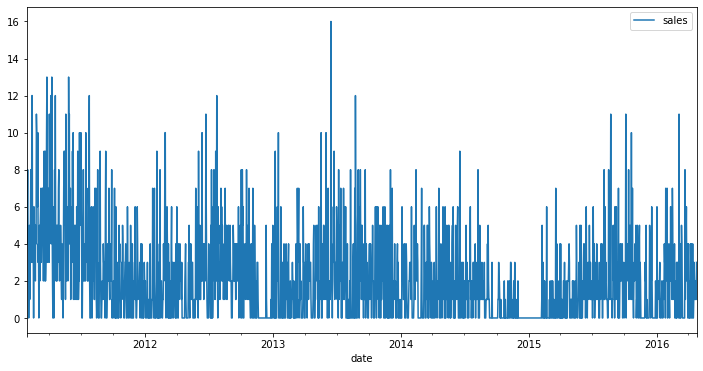

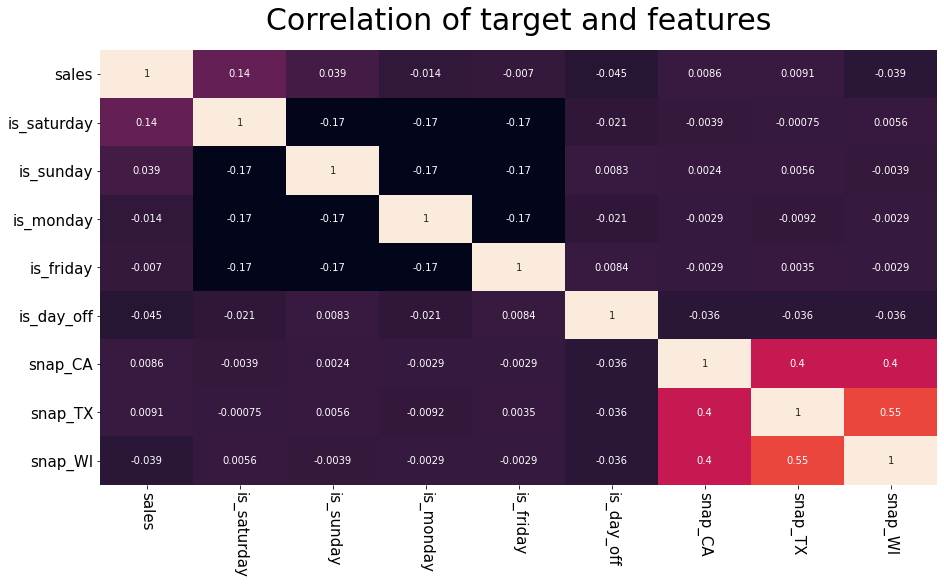

Target: 


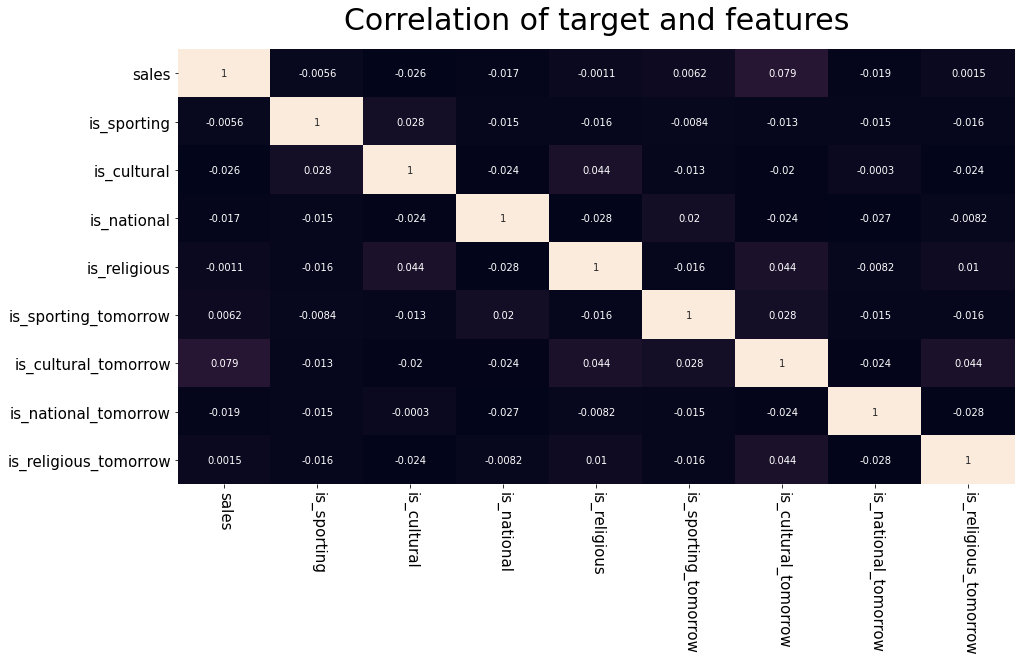

Target:


In [37]:
product = 'FOODS_1_054_CA_2_validation'

df = pd.DataFrame(sales_train_validation[sales_train_validation.id == product].iloc[0])
df = df.drop(axis=0, labels=['id','item_id','dept_id','cat_id','store_id','state_id'])
df = df.reset_index(drop=True)
df.columns = ["sales"]
df.sales = df.sales.astype('int')

df=pd.concat([df,date],axis=1)
df.dropna(inplace=True)
df['date']=pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

fig, ax = plt.subplots(figsize=(12,6))

df.plot(ax=ax)

collection = pd.concat([df, weekday_features, events_features, tomorrow_features, snap], axis=1).dropna()

showCorrelationDays()

showCorrelationEvents()